In [27]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [3]:
df = pd.read_csv("https://www.dropbox.com/s/l69lk72y5qwun8w/ZurichKreis.csv?dl=1")

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    LIMIT = 100
    radius = 2000
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Kreis', 
                  'Kreis Latitude', 
                  'Kreis Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
zurich_venues = getNearbyVenues(names = df['Kreis'], latitudes = df['Latitude'], longitudes = df['Longitude'])

1
2
3
4
5
6
7
8
9
10
11
12


### Find out in which Kreis Asian restaurants locate at most compared with other restaurants

In [24]:
df1 = zurich_venues[zurich_venues['Venue Category'].str.contains("Chinese")]
df2 = zurich_venues[zurich_venues['Venue Category'].str.contains("Asian")]
df3 = zurich_venues[zurich_venues['Venue Category'].str.contains("Thai")]
df4 = zurich_venues[zurich_venues['Venue Category'].str.contains("Vietnamese")]
df5 = zurich_venues[zurich_venues['Venue Category'].str.contains("Japanese")]
df6 = zurich_venues[zurich_venues['Venue Category'].str.contains("Tibetan")]
df7 = zurich_venues[zurich_venues['Venue Category'].str.contains("Indonesisch")]
total_restaurant = zurich_venues[zurich_venues['Venue Category'].str.contains("Restaurant")]
venues_asian = pd.concat([df1, df2, df3, df4, df5, df6,df7])

In [59]:
asian_rest = venues_asian.groupby('Kreis').count()
total_rest= total_restaurant.groupby('Kreis').count()
asian_rest_percentage = pd.DataFrame(100*asian_rest["Venue"]/total_rest["Venue"])
asian_rest_percentage.rename(columns={'Venue':'Asian Restaurant Percentage(%)'},inplace = True)
asian_rest_percentage.fillna(0, inplace=True)
asian_rest_percentage.reset_index(inplace=True)

### Get top 10 venues

In [9]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [10]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add Kries column back to dataframe
zurich_onehot['Kreis'] = zurich_venues['Kreis'] 

# move Kreis column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

# group rows by Kreis and by taking the mean of the frequency of occurrence of each category
zurich_grouped = zurich_onehot.groupby('Kreis').mean().reset_index()

# create columns according to number of top venues
columns = ['Kreis']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
kreis_venues_sorted = pd.DataFrame(columns=columns)
kreis_venues_sorted['Kreis'] = zurich_grouped['Kreis']

for ind in np.arange(zurich_grouped.shape[0]):
    kreis_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

kreis_venues_sorted

,Kreis,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Swiss Restaurant,Bar,Café,Plaza,Cocktail Bar,French Restaurant,Lounge,Hotel,Restaurant,Vegetarian / Vegan Restaurant
1,2,Swiss Restaurant,Bus Station,Supermarket,Restaurant,Tram Station,Park,Convenience Store,Burger Joint,Light Rail Station,Gas Station
2,3,Swiss Restaurant,Italian Restaurant,Supermarket,Hotel,Restaurant,Pizza Place,Bus Station,Scenic Lookout,Trail,Tram Station
3,4,Bar,Café,Swiss Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Coffee Shop,Italian Restaurant,Japanese Restaurant,Asian Restaurant,Bakery
4,5,Bar,Café,Thai Restaurant,Swiss Restaurant,Cocktail Bar,Asian Restaurant,Bakery,Park,Italian Restaurant,Japanese Restaurant
5,6,Café,Swiss Restaurant,Italian Restaurant,Bakery,Bar,Vegetarian / Vegan Restaurant,Hotel,Park,Middle Eastern Restaurant,Restaurant
6,7,Swiss Restaurant,Tram Station,Restaurant,Plaza,Bus Station,Bakery,Supermarket,Grocery Store,Hotel,Zoo
7,8,Swiss Restaurant,Italian Restaurant,Café,Park,Bar,Bakery,Plaza,Museum,Movie Theater,Coffee Shop
8,9,Supermarket,Swiss Restaurant,Restaurant,Bus Station,Bakery,Hotel,Italian Restaurant,Pizza Place,Convenience Store,Soccer Field
9,10,Bus Station,Supermarket,Swiss Restaurant,Train Station,Grocery Store,Restaurant,Fast Food Restaurant,Bathing Area,Hotel,Italian Restaurant


## The relationship between residents and restaurant business

In [11]:
zurich_bev = pd.read_excel("https://www.dropbox.com/s/58td1o6nl5u7jjd/BEV321T3211_Auslaenderanteil_Bevoelkerung_nach-Herkunft-Stadtkreis-Stadtquartier.xlsx?dl=1",
...               sheet_name='2018',skiprows = 8)

In [56]:
aus_bev = zurich_bev[zurich_bev['Unnamed: 0'].str.contains("Kreis")]
aus_bev.rename(columns={"Unnamed: 0":"Kreis", "Anteil\nausländische Bevölkerung\n(%)":"Foreigner Percentage(%)"},inplace = True)
aus_bev.reset_index(drop = True, inplace=True)
aus_bev.update(df)
aus_bev

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:4267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


,Kreis,Total,Schweizer/-innen,Ausländer/-innen,Foreigner Percentage(%)
0,1,5750,3992,1758,30.6
1,2,34877,23716,11161,32.0
2,3,50569,35548,15021,29.7
3,4,28729,18110,10619,37.0
4,5,15579,10556,5023,32.2
5,6,34321,24542,9779,28.5
6,7,38191,27350,10841,28.4
7,8,16788,10729,6059,36.1
8,9,55765,37723,18042,32.4
9,10,40341,29691,10650,26.4


In [13]:
nation_bev = pd.read_excel("https://www.dropbox.com/s/lcuyg4xghwemm1i/BEV336T3360_Bevoelkerung_nach-Nationalitaet-Stadtkreis-Stadtquartier.xlsx?dl=1",
...               sheet_name='2018',skiprows = 8)


In [58]:
nationalitat = nation_bev[nation_bev['Unnamed: 0'].str.contains("Kreis")]
kreis = nationalitat['Unnamed: 0']
asian = nationalitat['China']+nationalitat['Thailand']+nationalitat['Japan']+nationalitat['Südkorea']+nationalitat['Vietnam']+nationalitat['Indonesien']+nationalitat['Chinesisches Taipei']+nationalitat['Singapur']
asian_tot = pd.concat([kreis,asian],axis = 1)
asian_percentage =100* asian_tot[0]/nationalitat["Total"]
asian_percent = pd.concat([kreis,asian_percentage],axis = 1)
asian_percent.rename(columns={"Unnamed: 0":"Kreis",0:"Asian Resident Percentage(%)"},inplace = True)
asian_percent.reset_index(drop = True, inplace=True)
asian_percent.update(df)
asian_percent

,Kreis,Asian Resident Percentage(%)
0,1,1.008696
1,2,0.785618
2,3,0.632799
3,4,1.019875
4,5,0.699660
5,6,0.897410
6,7,0.882407
7,8,0.941148
8,9,0.869721
9,10,1.038646


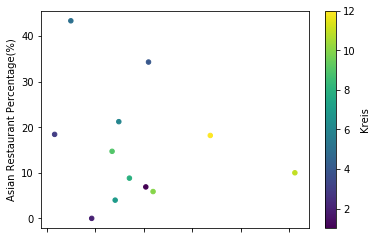

In [60]:
df_scatter = pd.concat([asian_percent,asian_rest_percentage["Asian Restaurant Percentage(%)"],aus_bev['Foreigner Percentage(%)']],axis = 1)
ax1 = df_scatter.plot.scatter(x='Asian Resident Percentage(%)',y='Asian Restaurant Percentage(%)',c='Kreis',colormap='viridis')
ax1

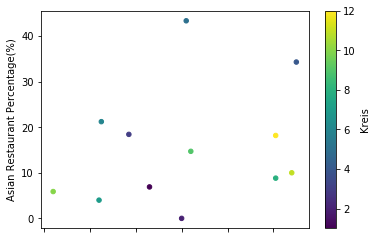

In [61]:
ax2 = df_scatter.plot.scatter(x='Foreigner Percentage(%)',y='Asian Restaurant Percentage(%)',c='Kreis',colormap='viridis')
ax2

,Unnamed: 0,Asian Resident Percentage
1,Kreis 1,1.008696
6,Kreis 2,0.785618
10,Kreis 3,0.632799
14,Kreis 4,1.019875
18,Kreis 5,0.699660
21,Kreis 6,0.897410
24,Kreis 7,0.882407
29,Kreis 8,0.941148
33,Kreis 9,0.869721
36,Kreis 10,1.038646
